# Lab 1: Segmentacion

Debe formar grupo de hasta 3 personas para los laboratorios.

__Estudiante 1:__ Leonardo Achá Boiano \
__Estudiante 2:__ Bruno Ramiro Rejas Montero \
__Estudiante 3:__ Matias Adorno Mazzocato

__Fecha de inicio:__ 2 de Marzo del 2023 \
__Fecha de entrega:__ 20 de Marzo del 2023 (11:59 pm)

## Importante

El objetivo de los laboratorios es mostrar la implementación práctica de los temas presentados durante la clase, así como preparar los para el proyecto final, que es un proyecto práctico que une los temas del curso.

Como tal, en los  laboratorios/proyecto final, a menos que se especifique lo contrario, debe utilizar funciones de procesamiento de imágenes/libraries como ser `opencv` y `sklearn`. 

Sin embargo, por cada funcion utilizada se debe dar una explicación suficiente en el informe de laboratorio. Note que no se necesita implementar un detector de bordes propio, etc.

Por otro lado, existen algunas funciones, algoritmos, que no estan presentes en `opencv` como por ejemplo `region growing`. Como ya se menciono, no se quiere que lo implementen desde cero si no que busquen en otras librerias para utilizar dicho algoritmo. Una libreria que se usa en conjunto con `opencv` es `sklearn` (Note que puede realizar el laboratorio utilizando solamente una libreria pero si lo desea puede usar ambas). 

Para instalar la libreria scikit-image corra el siguiente comando ([scikit-image](https://scikit-image.org/docs/stable/install.html#install-via-pip)):

```bash
python -m pip install -U scikit-image
```


A continuacion, se muestra algunas funciones de `scikit-image` que le podria ser de utilidad:

- skimage.exposure.is_low_contrast
- exposure.rescale_intensity
- skimage.measure.label
- skimage.color.label2rgb
- skimage.measure.regionprops
- scipy.ndimage.gaussian_laplace (OpenCV tambien permite realizar el LOG)

Entre otros metodos. Revise la documentacion.

Note que debe guardar todos los experimentos posibles para documentar la elaboracion del laboratorio.

**Antes de entregar la notebook <font color='red'> rerun </font>la notebook from scratch !**
`Kernel` > `Restart & Run All`

## Extraer la Data

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.getcwd(), 'images')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Parte 1: Segmentacion

__Objetivo:__ calcular el tamaño del cerebro (sin el cráneo) en píxeles en una imagen 2D de una cabeza humana tomada por Imágenes por resonancia magnética (MRI) mediante:

* Region growing (5 pts)
* Detección de contornos (5 pts)
    - LOG
    - Sobel
    - Canny 

Cada sección debe mostrar la segmentación resultante, así como el tamaño en píxeles de la región detectada. Tambien, debe realizar comentarios, limitaciones y/o ventajas de cada método.

Analice sus resultados, pruebe todas las formas posibles (mientras mas mejor). Nuevamente, no se rompera nada si probamos varios metodos. Recuerde siempre hacer una copia original de la imagen.


__Importante__
Guardar la imagen en con la cantidad de pixeles en cada iteracion y comparar los resultados bajo distintos metodos.

## Visualizacion de la imagen

In [2]:
import skimage.io
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

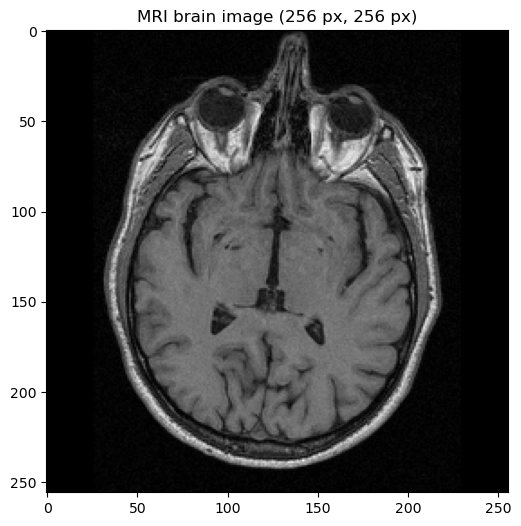

(256, 256)


In [3]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape
brain_img=brain_im.copy()

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title(f'MRI brain image ({im_h} px, {im_w} px)')
ax.axis('on')
plt.show()
print(brain_img.shape)

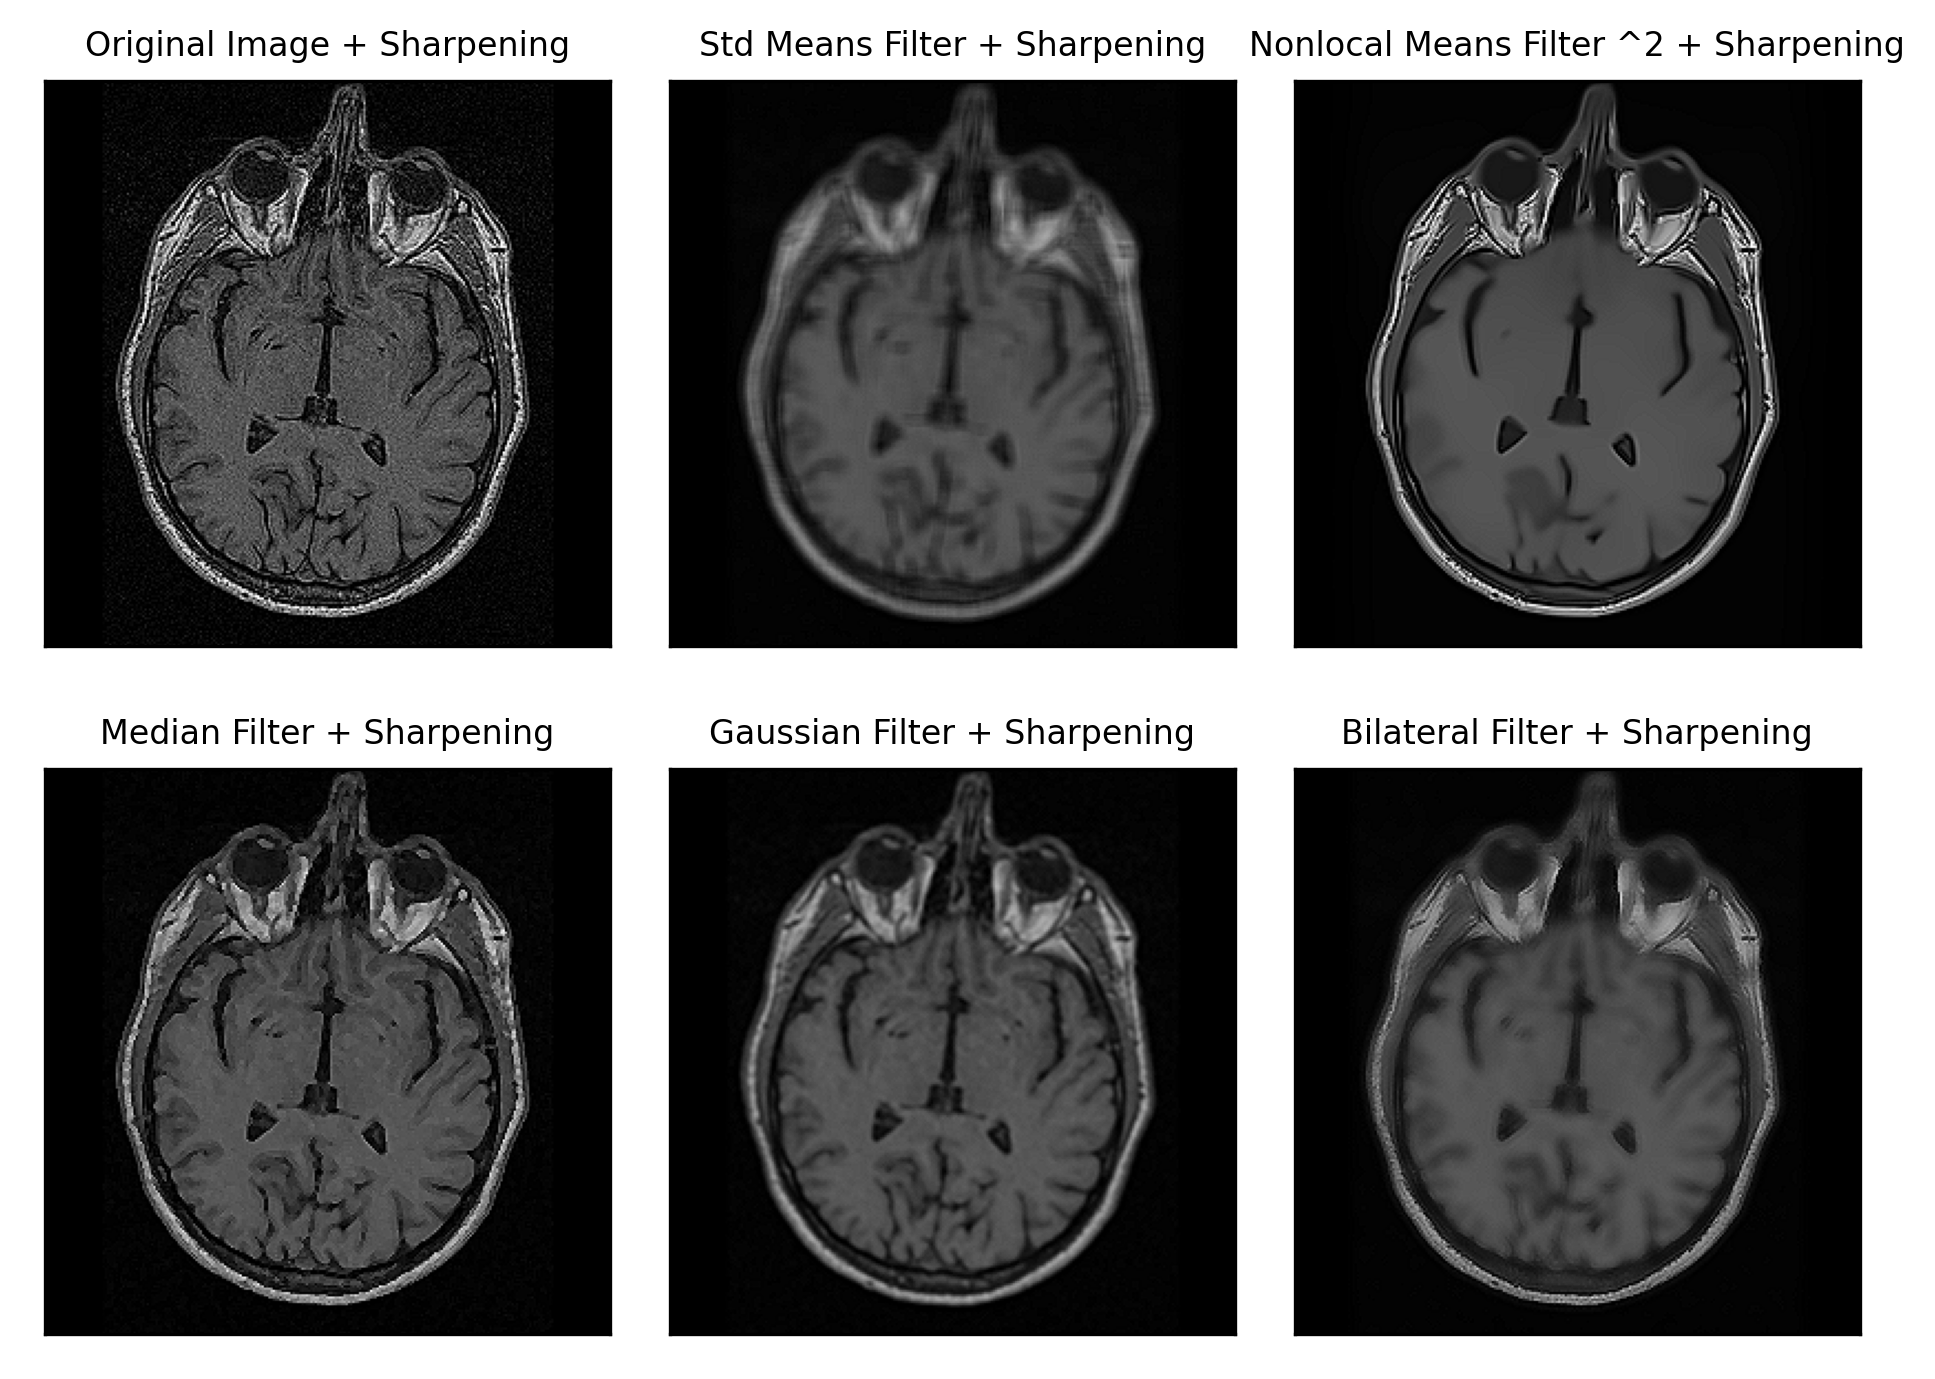

In [4]:
#image filtering
filters_str=['Original Image','Std Means Filter',
             'Nonlocal Means Filter ^2','Median Filter',
             'Gaussian Filter', 'Bilateral Filter']
images=[brain_img]
filter_size=6
low_pass_kernel=np.ones((filter_size,filter_size),np.float32)/filter_size**2
images.append(cv2.filter2D(src=brain_img, 
                           ddepth=-1, kernel=low_pass_kernel)) #standart mean filter
images.append(cv2.fastNlMeansDenoising(brain_img, 
                                        templateWindowSize=7,
                                        searchWindowSize=21,
                                        h=10)) #Nonlocal means denoising algorithm
images[2]=cv2.fastNlMeansDenoising(images[2], 
                                        templateWindowSize=7,
                                        searchWindowSize=21,
                                        h=10) #Nonlocal means denoising algorithm
images.append(cv2.medianBlur(brain_img, 3))
images.append(cv2.GaussianBlur(brain_img,(5,5),0)) #gaussian filter
images.append(cv2.bilateralFilter(brain_img, 9,60,60)) #bilateral filter

sharpen_kernel=np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
for i in range(len(images)):
    images[i]=sharpenOutput=cv2.filter2D(src=images[i], ddepth=-1, kernel=sharpen_kernel)

fig=plt.figure(dpi=300)
for i in range(len(images)):
    fig.add_subplot(2,3,i+1)
    plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(f"{filters_str[i]} + Sharpening", fontsize=8)
    plt.xticks([]),plt.yticks([])
plt.tight_layout()
plt.show()


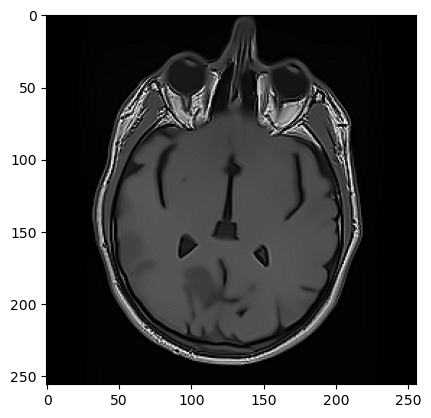

In [5]:
plt.imshow(images[2],'gray',vmin=0,vmax=255)

## 1.1 Region growing (5 pts)

Region growing is an iterative method used to extract similar parts of an image. One or several points are chosen as a start. The region then grows until it is finally blocked by the stop criteria. This criteria is generally an inside/outside region comparison (energy, size, . . .).  

In [6]:
# YOU CODE HERE AND DISCUSSION
def region_growing(img, seed, tolerance=0.1, color=255):
    """
    Segment an image using region growing.
    
    Args:
        img (np.ndarray): The input image.
        seed (tuple): The pixel coordinates (x, y) of the seed point.
        tolerance (float): Allowed difference between seed value and neighborhood
        color (int) = mask color
    
    Returns:
        np.ndarray: The segmented image mask.
    """
    # Initialize segmented image with zeros
    segmented = np.zeros_like(img)
    
    # Initialize queue with seed point
    queue = [seed]
    
    # Get seed point color
    seed_color = img[seed]
    
    # Loop until the queue is empty
    while queue:
        # Get next pixel from queue
        pixel = queue.pop(0)
        
        # Check if pixel is within image bounds
        if (0 <= pixel[0] < img.shape[0]) and (0 <= pixel[1] < img.shape[1]):
            # Check if pixel is unsegmented and similar to seed color
            if segmented[pixel[0], pixel[1]] == 0 and np.allclose(img[pixel], seed_color, rtol=tolerance, atol=tolerance):
                # Segment pixel
                segmented[pixel[0], pixel[1]] = color
                
                # Add neighboring pixels to queue
                queue.append((pixel[0] - 1, pixel[1]))
                queue.append((pixel[0] + 1, pixel[1]))
                queue.append((pixel[0], pixel[1] - 1))
                queue.append((pixel[0], pixel[1] + 1))
    
    return segmented


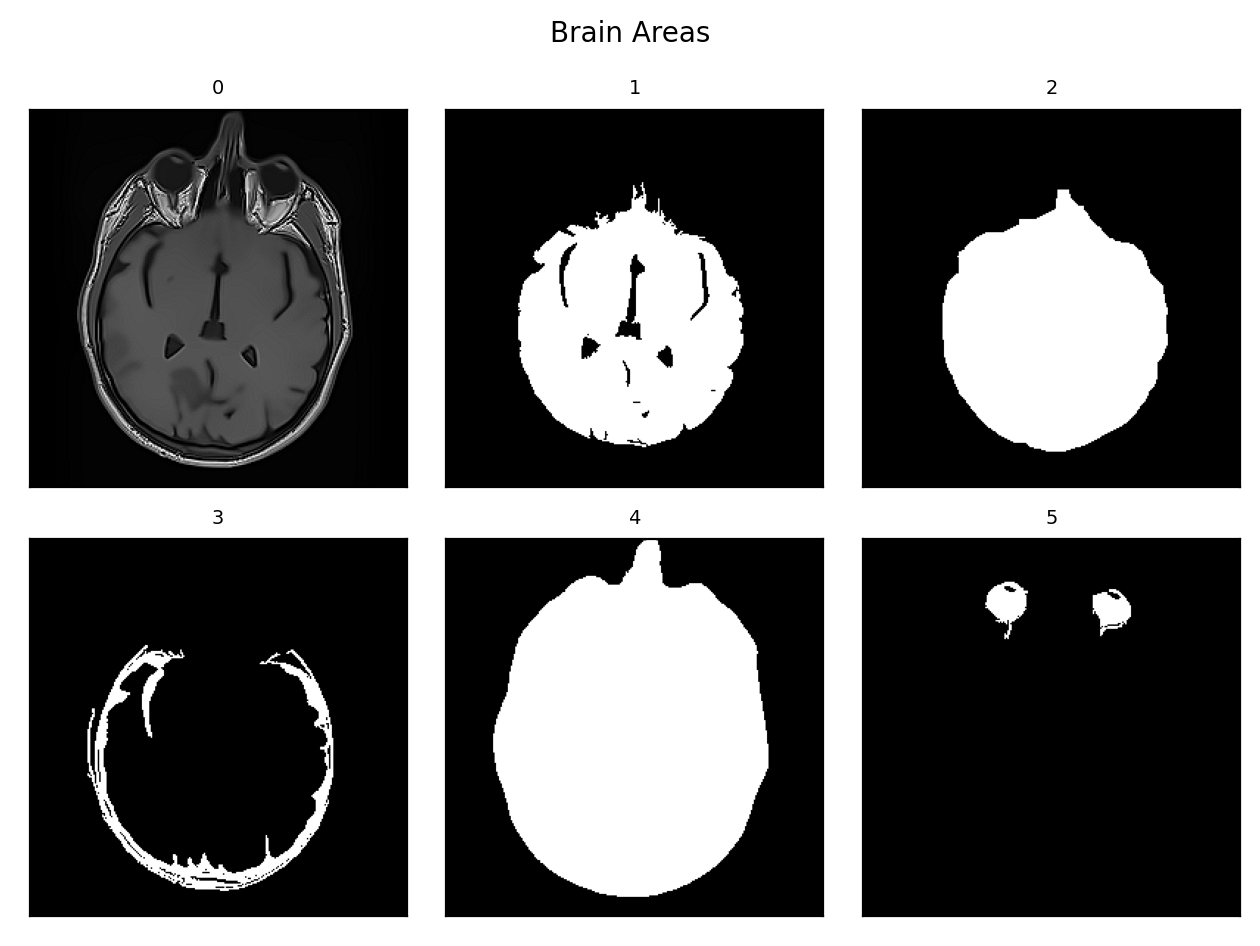

In [8]:
brain_areas=[images[2]]

# Apply region growing segmentation
brain_areas.append(region_growing(images[2], (100, 100), 0.5))
brain_areas.append(cv2.morphologyEx(brain_areas[1], cv2.MORPH_CLOSE, 
                    cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4)),
                    iterations=5))
brain_areas.append(region_growing(images[2], (175, 50), 0.99))
brain_areas.append(cv2.bitwise_not(region_growing(images[2], (50, 250), 10)))
brain_areas.append(region_growing(images[2], (50, 100), 1)+region_growing(images[2], (50, 175), 1))

# Display results
fig=plt.figure(dpi=200)
for i in range(len(brain_areas)):
    fig.add_subplot(2,3,i+1)
    plt.imshow(brain_areas[i],'gray',vmin=0,vmax=255)
    plt.title(i, fontsize=7)
    plt.xticks([]),plt.yticks([])
plt.tight_layout()
fig.suptitle('Brain Areas', fontsize=10)
plt.subplots_adjust(top=0.9)
plt.show()

fig.savefig("results/Ex1.1-Brain-Areas.png",bbox_inches='tight')

In [9]:
print(f"El area del cerebro está en el rango de {np.count_nonzero(brain_areas[1] == 255)} a {np.count_nonzero(brain_areas[2] == 255)} pixeles.")

El area del cerebro está en el rango de 18222 a 19506 pixeles.


## 1.2 Contour detection (5 pts)

In [8]:
# YOU CODE HERE AND DISCUSSION

---
## Parte 2: Segmentacion Forma/Color 

A continuación encontrará tres fotografías tomadas bajo tres iluminaciones diferentes, que contienen algunas formas con diferentes colores. Se pide que se cree una funcion para:

1. Contar el número de formas de cada color (solo color no distinción entre formas) (5pts).
2. Calcular el área total (en píxeles) de cada color (5 pts).

Note que esta funcion debe detectar realizar los pasos anteriores bajo cualquier ilumniacion. Por esto, tenga en cuenta que un desafío específico es ser resistente a los cambios de iluminación. Por lo tanto, en algun tipo de intensidad probablemente se debería realizar la normalizacion.

__Sugerencia__: el espacio de color RGB podría no ser óptimo. Considere usar el espacio de color HSV o LAB.

## 2.1 Visualizacion

In [33]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]

images = []
for filename in filenames:
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if img is not None:
        images.append(img)
        

print(f'Number of images: {len(images)}')
print(f'Image size: {images[0].shape[:2]}')
print(f'Number of color channels: {images[0].shape[-1]}')

Number of images: 3
Image size: (480, 640)
Number of color channels: 3


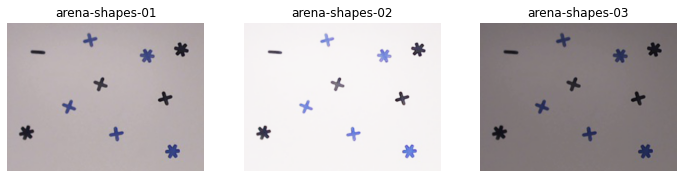

In [34]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

## 2.2 Numero de formas (shapes) de cada color (5 pts)

In [36]:
# YOU CODE HERE AND DISCUSSION

## 2.3 Area total (en pixeles) de cada color (5 pts)

In [ ]:
# YOU CODE HERE AND DISCUSSION